# Figures for QPGA paper


In [40]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qutip

from qpga import *
from qpga.circuits import QFT, QFT_layer_count
from qpga.training import build_and_train_qpga

from tensorflow.python.keras import backend as K
K.set_floatx('float64')

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3, linewidth=300)

## Fidelity search plot

In [2]:
num_qubits = [3,4,5,6,7,8]
num_layers_explicit = [QFT_layer_count(n, nearest_neighbor_only=True, include_reshuffling=True) for n in num_qubits]
num_layers_SGD = [7, 11] + [25, 40, 55, 70] # last bit are made up, will fill in when computations finish

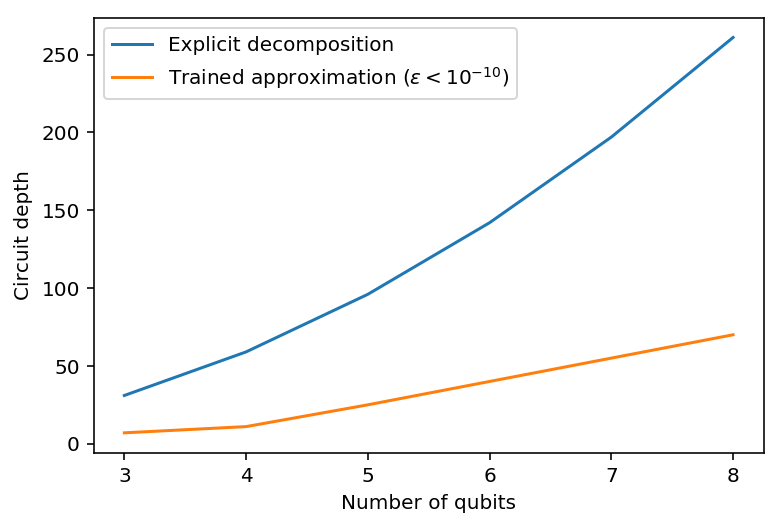

In [3]:
plt.plot(num_qubits, num_layers_explicit, label="Explicit decomposition")
plt.plot(num_qubits, num_layers_SGD, label="Trained approximation ($\epsilon < 10^{-10}$)")
plt.xlabel("Number of qubits")
plt.ylabel("Circuit depth")
plt.legend()
# plt.savefig("circuit_depth.png")
plt.show()

## QFT plot

In [35]:
N = 5
in_data, out_data = prepare_training_data(QFT, N, 10000)

100%|██████████| 10000/10000 [00:20<00:00, 480.84it/s]


In [42]:
model, _ = build_and_train_qpga(40, in_data, out_data, max_epochs = 10, target_antifidelity = 1e-10)

Instantiating model with 5 qubits and depth of 40...
Building model...
Done building.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 32)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 32)                20        
_________________________________________________________________
c_phase_layer_90 (CPhaseLaye (None, 32)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 32)                20        
_________________________________________________________________
c_phase_layer_91 (CPhaseLaye (None, 32)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 32)                20        
__________________________________

In [43]:
operator = extract_operator_from_model(model, N)
operator_targ = extract_operator_from_circuit(QFT, N)

global_phase = np.mean(np.angle(operator/operator_targ))
operator /= np.exp(1j * global_phase)

In [56]:
def _blob(x, y, w, w_min, w_max, area, cmap=None, ax=None):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    
    handle = ax if ax is not None else plt   
    # color = int(256 * (w - w_min) / (w_max - w_min))
    color=(w - w_min) / (w_max - w_min)
    handle.fill(xcorners, ycorners, color=cmap(color))
    

def computational_basis_labels(num_qubits, include_bras=True):
    """Creates plot labels for matrix elements in the computational basis."""
    N = 2 ** num_qubits
    basis_labels = [format(i, 'b').zfill(num_qubits) for i in range(N)]
    
    kets = [r"$\left|{}\right>$".format(l) for l in basis_labels]
    if include_bras:
        bras = [r"$\left<{}\right|$".format(l) for l in basis_labels]
        return [kets, bras]
    else:
        return kets

        
def hinton(W, xlabels=None, ylabels=None, title=None, fig=None, ax=None, cmap=None):
#     cmap = plt.get_cmap('hsv')
    cmap = plt.get_cmap('twilight')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))

    if not (xlabels or ylabels):
        ax.axis('off')

    ax.axis('equal')
    ax.set_frame_on(False)

    height, width = W.shape
    ax.set(xlim=(0,width), ylim=(0,height))

    max_abs = np.max(np.abs(W))
    scale = 0.7

    for i in range(width):
        for j in range(height):
            x = i + 1 - 0.5
            y = j + 1 - 0.5
            _blob(x, height - y, np.angle(W[i, j]), -np.pi, np.pi, 
                  np.abs(W[i, j]) / max_abs * scale, cmap=cmap, ax=ax)

    # x axis
    ax.xaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    if xlabels:
        ax.set_xticklabels(xlabels, rotation='vertical')
        ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelsize=9, pad=0)
    ax.xaxis.set_ticks_position('none') 

    # y axis
    ax.yaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax.yaxis.set_ticks_position('none') 
    if ylabels:
        ax.set_yticklabels(list(reversed(ylabels)))
    ax.tick_params(axis='y', labelsize=9, pad=0)
    
    # color axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad='2%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                     norm=mpl.colors.Normalize(-np.pi, np.pi),
                                     ticks=[])
#                                      ticks=[-np.pi, 0, np.pi])
    cax.text(0.5, 0.0, '$-\pi$', transform=cax.transAxes, va='top', ha='center')
    cax.text(0.5, 1.0, '$+\pi$', transform=cax.transAxes, va='bottom', ha='center')
#     cbar.ax.set_yticklabels(['$-\pi$','$0$','$+\pi$'])
    
    return fig, ax

def loss_plot(losses, x_units="epochs", x_max=None, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))
        
    ax.plot(losses)
    ax.fill_between(np.arange(len(losses)), losses, alpha=0.1)
    ax.set_xlim(0, x_max-1)
    ax.set_ylim(0, 1)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("Fidelity $\mathcal{F} = \left<\psi|\tilde{\psi}\right>")
    if x_units == 'epochs':
        ax.set_xlabel("Epochs")
    elif x_units == 'iterations':
        ax.set_xlabel("Iterations")
    elif x_units == 'none':
        ax.set_xticks([])
        
    return fig, ax

In [ ]:
class OperatorVisCallback(Callback):

    def __init__(self):
        super().__init__()
        self.fidelities_train = []
        self.fidelities_val = []
        self.operators = []

    def on_epoch_end(self, epoch, logs = None):
        self.fidelities_train.append(1 - logs.get('antifidelity'))
        self.fidelities_val.append(1 - logs.get('val_antifidelity'))
        self.operators.append(extract_operator_from_model(self.model))

In [ ]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Plot operator visualizations
kets, bras = computational_basis_labels(N, include_bras=True)

hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax1)
hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax2)

# Plot antifidelity
ax_bot = fig.add_subplot(gs[1, :])
loss_plot(fidelities, x_units='iterations', fig=fig, ax=ax_bot)

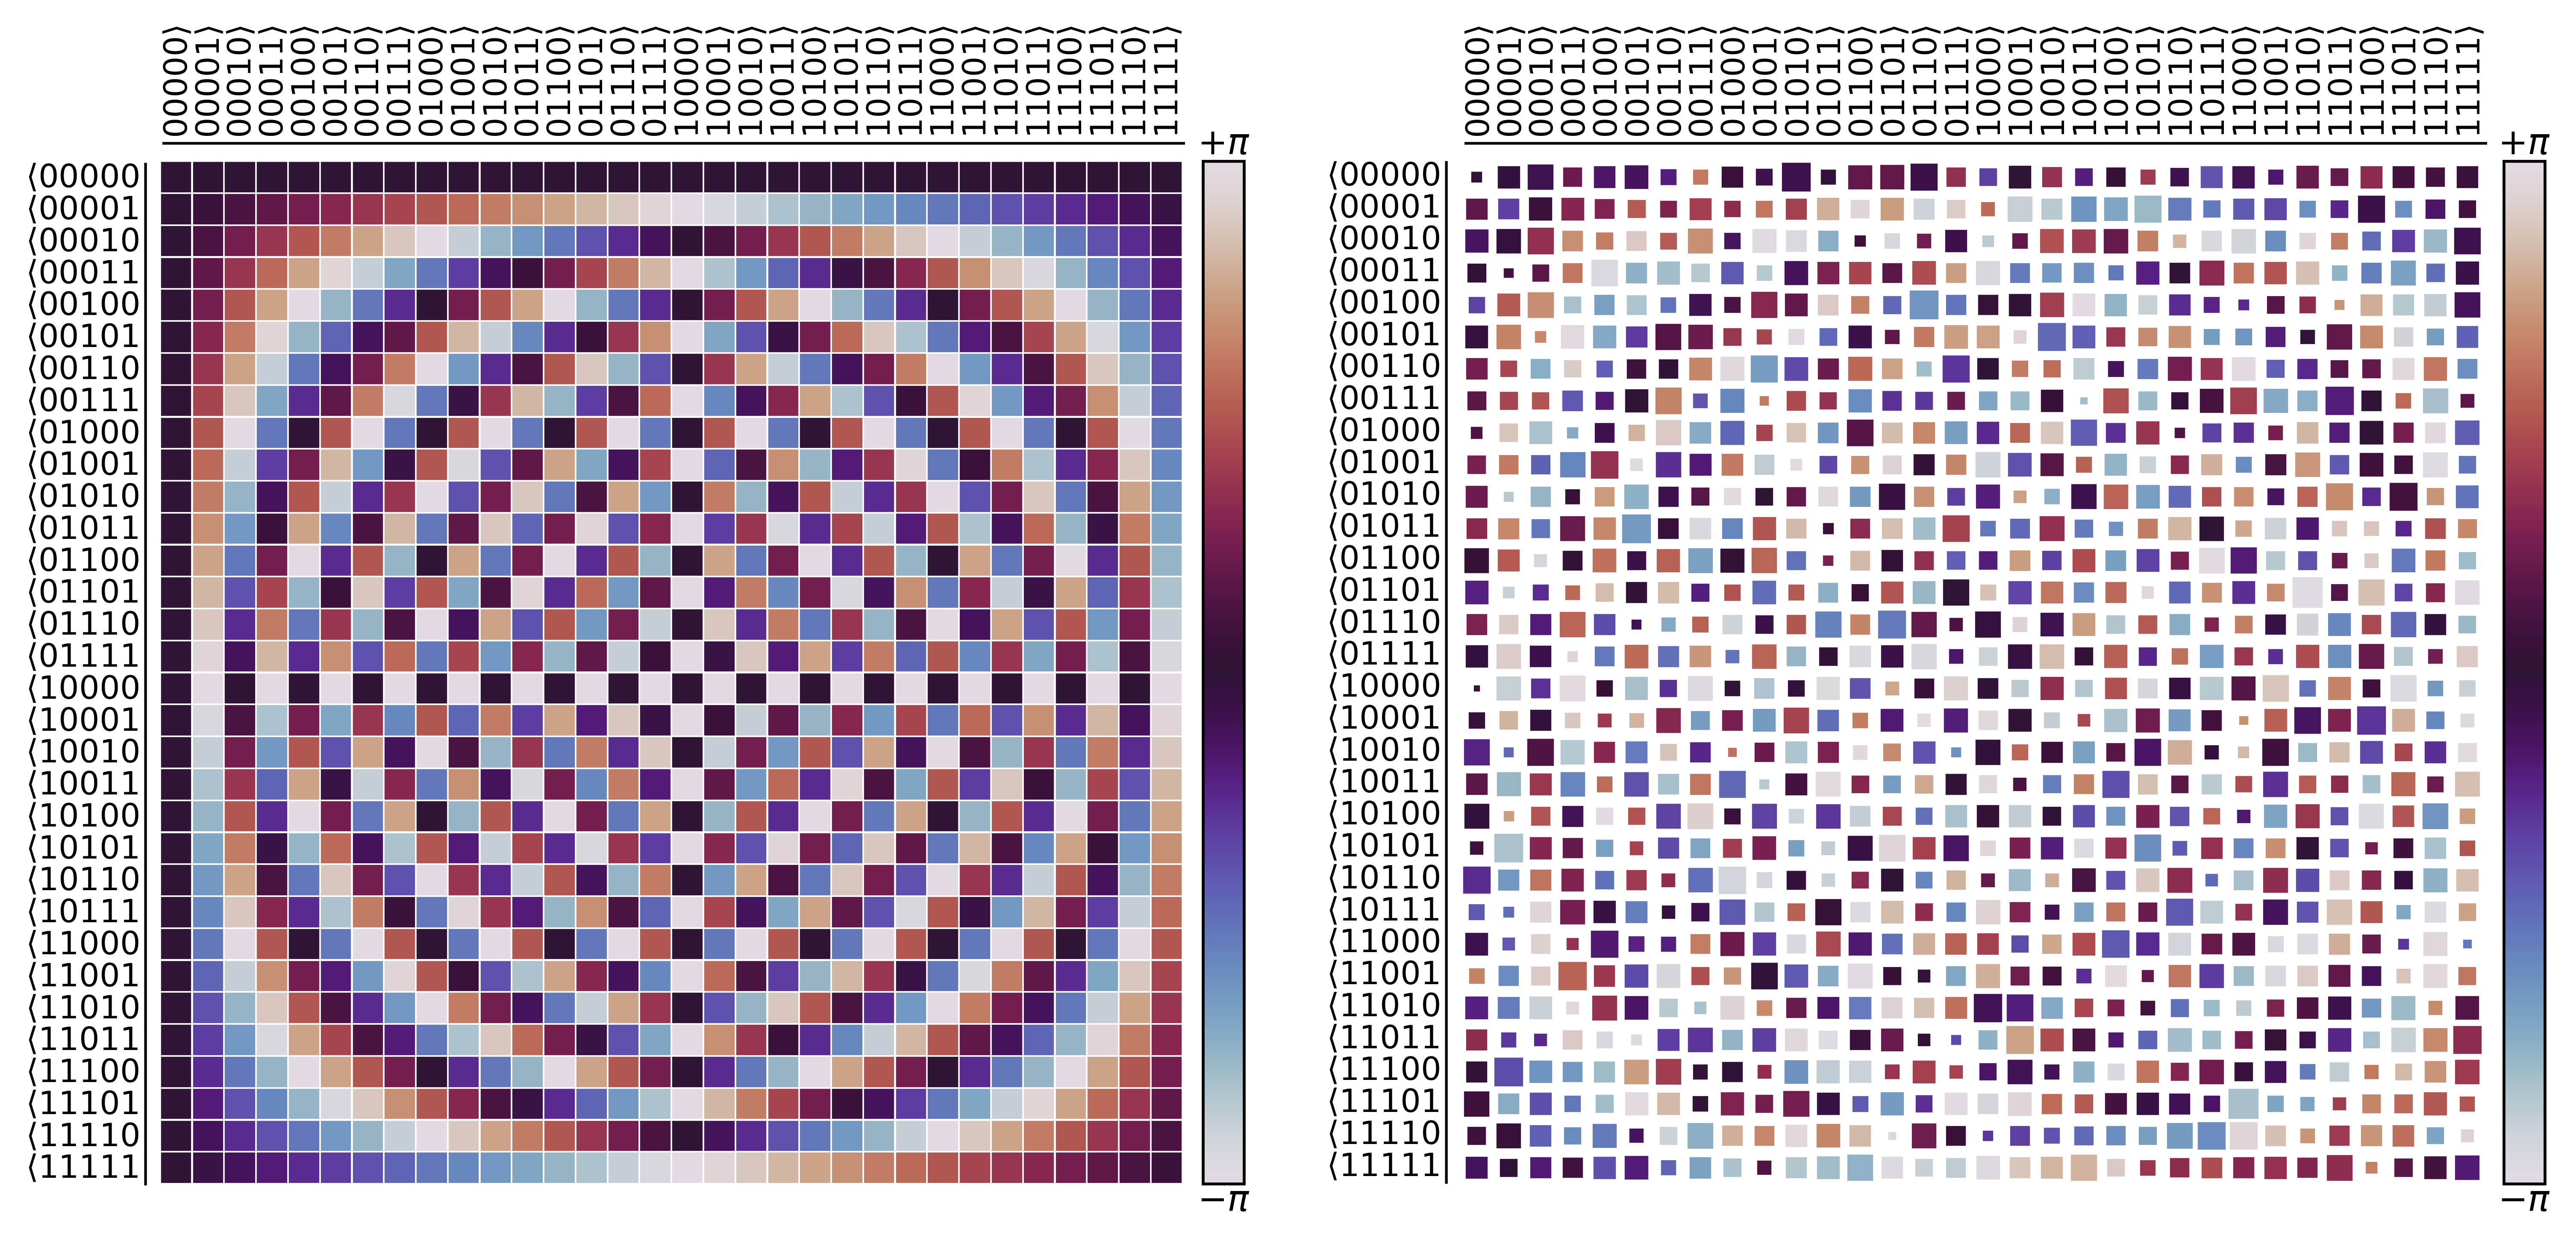

In [57]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,6))

kets, bras = computational_basis_labels(N, include_bras=True)

operator_targ = extract_operator_from_circuit(QFT, 5)

hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax1)
hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax2)
plt.show()
# plt.savefig("assets/qft.png", dpi=300, bbox_inches='tight', pad_inches=0)

(<Figure size 2400x1800 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1acdd8c3c8>)

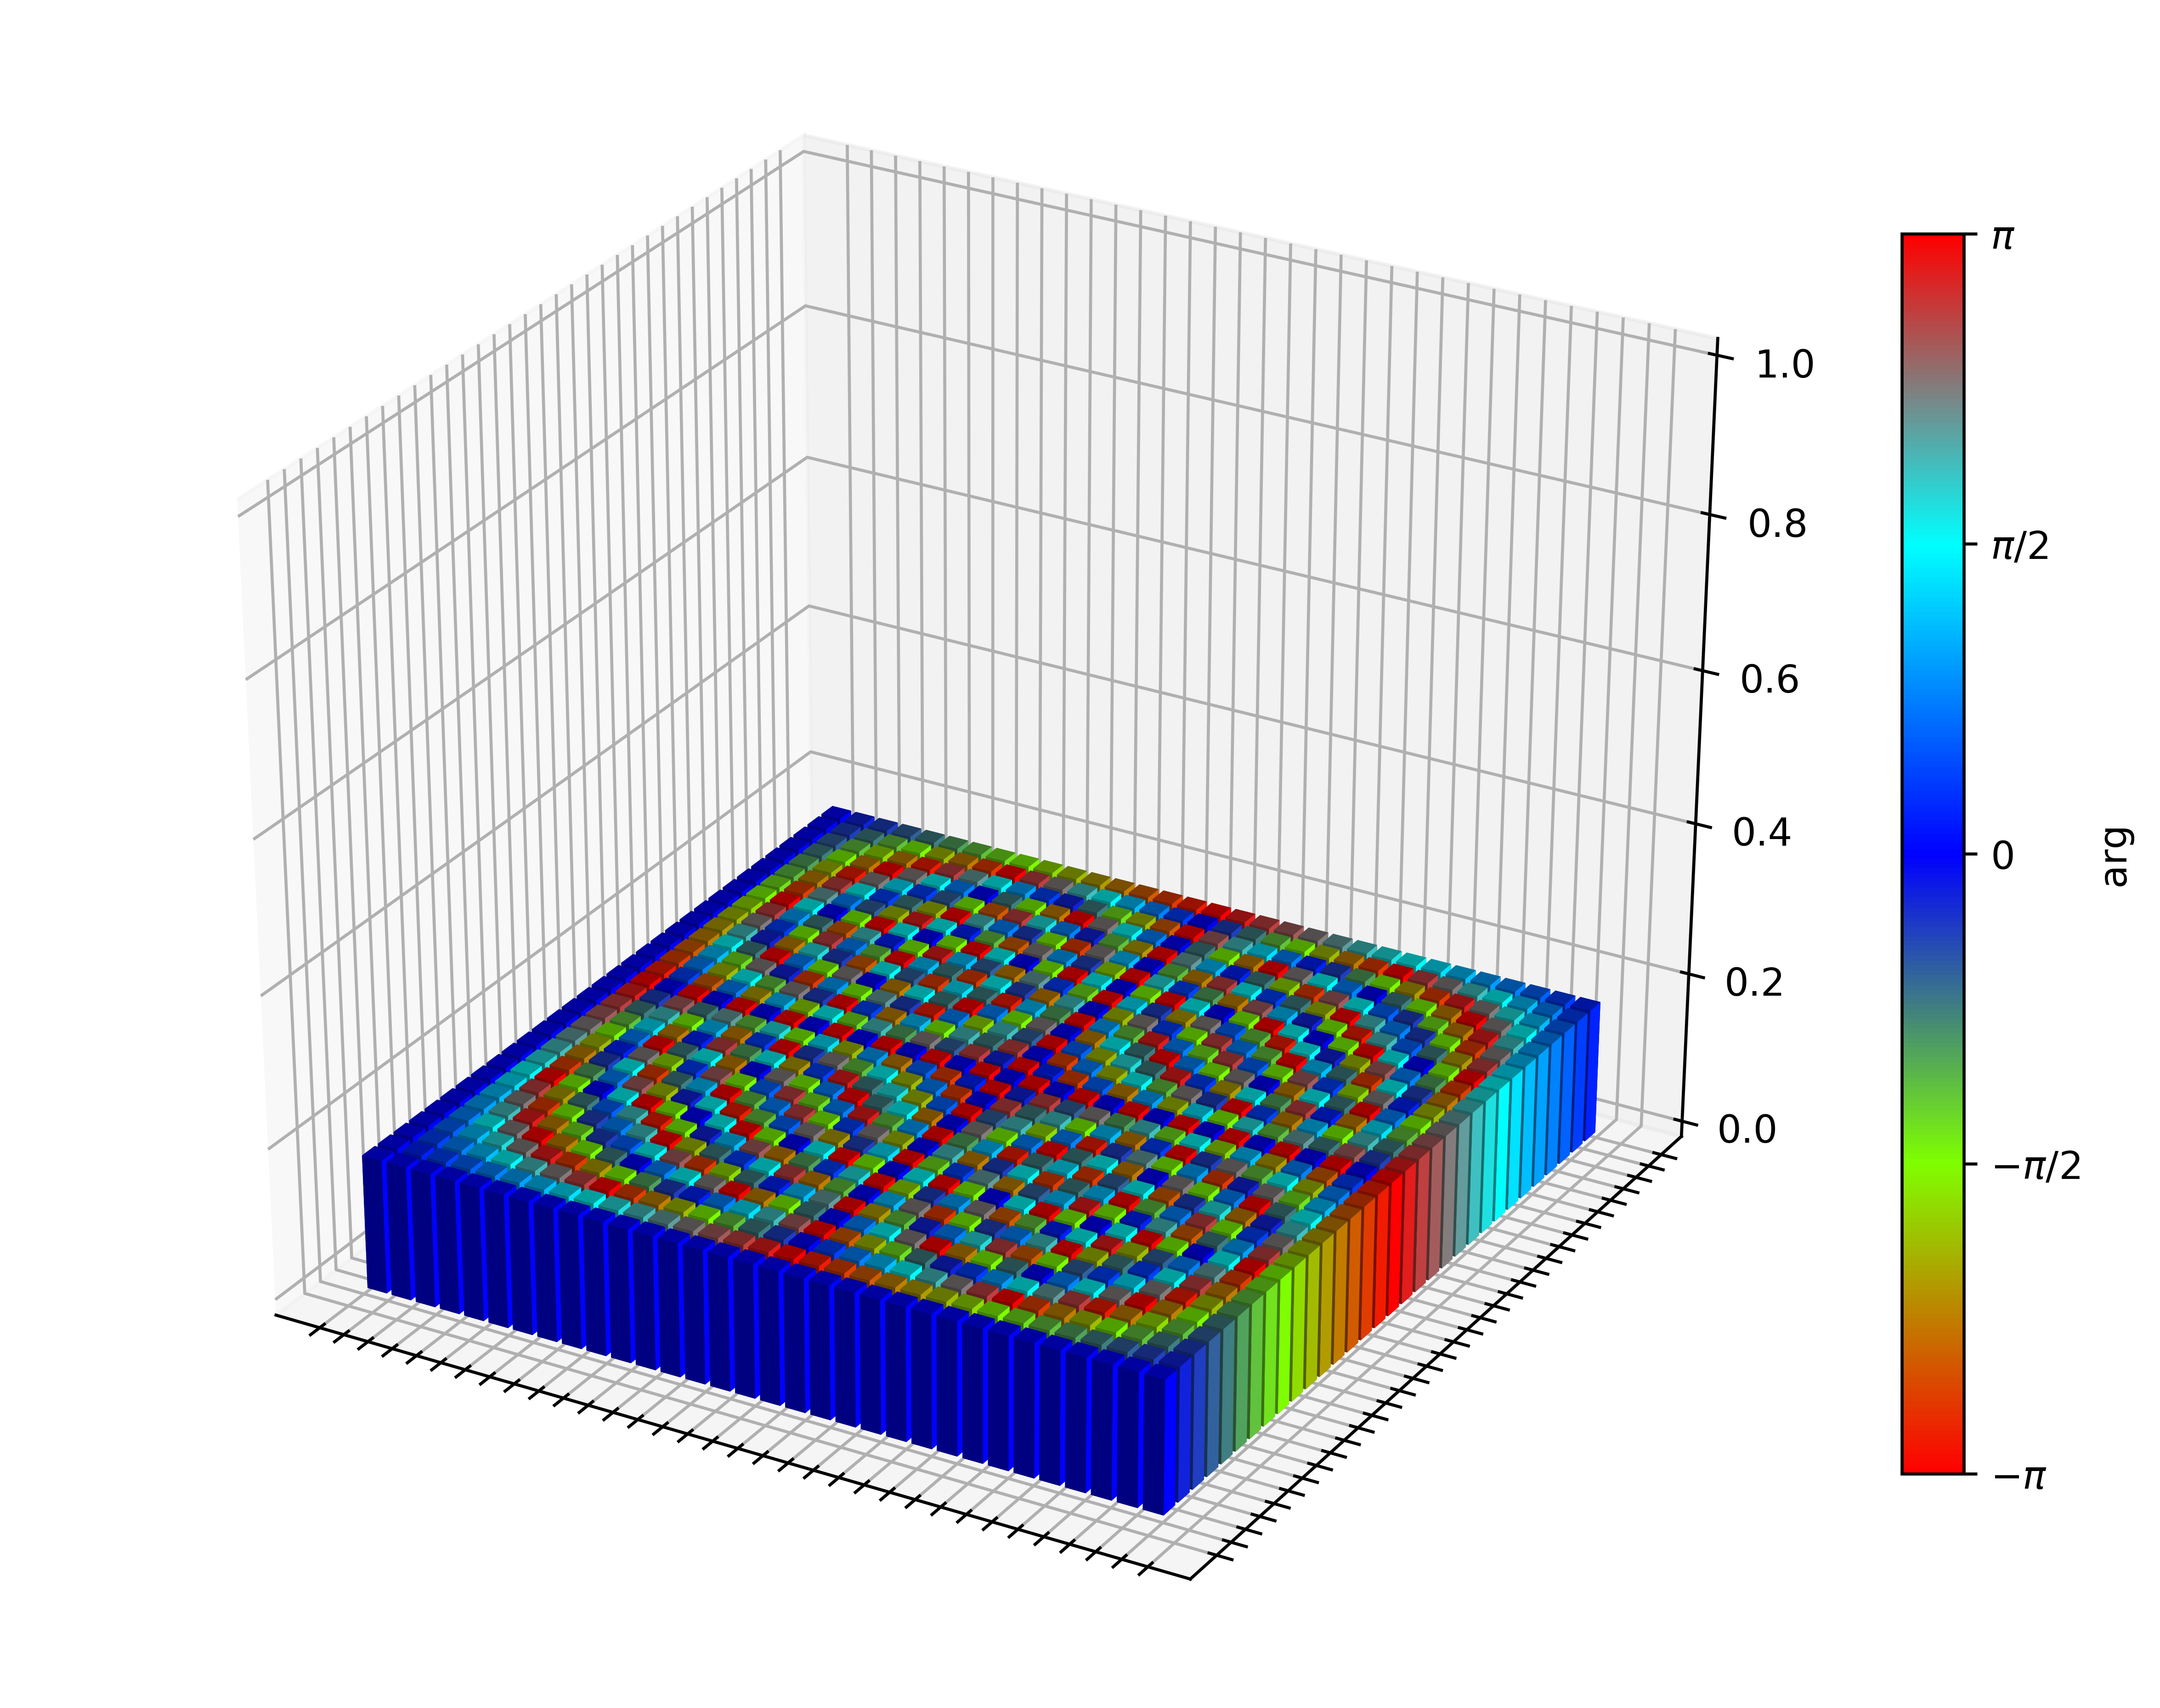

In [47]:
qutip.qpt_plot_combined(operator_targ,[])

In [303]:
print(operator_targ)

[[ 3.536e-01+0.j     3.536e-01+0.j     3.536e-01+0.j     3.536e-01+0.j     3.536e-01+0.j     3.536e-01+0.j     3.536e-01+0.j     3.536e-01+0.j   ]
 [ 3.536e-01+0.j    -3.536e-01+0.j     2.165e-17+0.354j -2.165e-17-0.354j  2.500e-01+0.25j  -2.500e-01-0.25j  -2.500e-01+0.25j   2.500e-01-0.25j ]
 [ 3.536e-01+0.j     3.536e-01+0.j    -3.536e-01+0.j    -3.536e-01+0.j     2.165e-17+0.354j  2.165e-17+0.354j -2.165e-17-0.354j -2.165e-17-0.354j]
 [ 3.536e-01+0.j    -3.536e-01+0.j    -2.165e-17-0.354j  2.165e-17+0.354j -2.500e-01+0.25j   2.500e-01-0.25j   2.500e-01+0.25j  -2.500e-01-0.25j ]
 [ 3.536e-01+0.j     3.536e-01+0.j     3.536e-01+0.j     3.536e-01+0.j    -3.536e-01+0.j    -3.536e-01+0.j    -3.536e-01+0.j    -3.536e-01+0.j   ]
 [ 3.536e-01+0.j    -3.536e-01+0.j     2.165e-17+0.354j -2.165e-17-0.354j -2.500e-01-0.25j   2.500e-01+0.25j   2.500e-01-0.25j  -2.500e-01+0.25j ]
 [ 3.536e-01+0.j     3.536e-01+0.j    -3.536e-01+0.j    -3.536e-01+0.j    -2.165e-17-0.354j -2.165e-17-0.354j  2.165e-

In [239]:
import cmocean

ModuleNotFoundError: No module named 'cmocean'

In [314]:
np.array(list(map(int, format(7, 'b').zfill(3))), dtype=np.complex128)

array([1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])